In [1]:
# Unfinished code: originally I want to just load the data, make some plots, and save outputted images for data processing. The plots and basic inspections are finished,
# but I did not proceed to save the outputs, as I now realized that the vorticity runs give strange behaviours (see hw_vortdiv_nobatchnorm_smallbatch_cosonly*)
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import r2_score as R2
from sklearn.model_selection import KFold
from copy import deepcopy
import utils
from unet import UNet_nobatchnorm
from scipy.stats import pearsonr
from pathlib import Path
import numpy.fft as fft
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import helper_functions as hf

In [2]:
root_dir = '/work/uo0780/u241359/project_tide_synergy/data/'
nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)
Ntrain = np.sum([nc.dimensions['time_counter'].size for nc in nctrains], axis = 0)
Ntest = np.sum([nc.dimensions['time_counter'].size for nc in nctest], axis = 0)

model_folder = '/work/uo0780/u241359/project_tide_synergy/trainedmodels_forpaper/'
filesuffix='_ssh_cosssh_sin_nobatchnorm_rp_0.pth'

vel_cmap  = 'BrBG' #'viridis'
vort_cmap = 'PRGn'
ssh_cmap  = 'bwr'
sst_cmap = 'inferno'
snap_index = 100

bottom_slice = slice(0,256)
mid_slice = slice(232, 488)
top_slice = slice(464, 720)

def corr(data, mod):
    return pearsonr(data.flatten(), mod.flatten())[0]
def L2_R(data,mod):
    return R2(data.flatten(), mod.flatten())
def performance_metrics(data, mod):
    return corr(data, mod), L2_R(data,mod)

def hwvorticity(u, v, dgrid = 4000):
    return (np.gradient(v, axis =2) - np.gradient(u, axis =1))/dgrid

def hwdivergence(u, v, dgrid = 4000):
    return (np.gradient(u, axis =2) + np.gradient(v, axis =1))/dgrid

In [3]:
Nbase = 16
def totorch(x):
    return torch.tensor(x, dtype = torch.float).cpu()
    
def preload_data_vortdiv(nctrains, total_records):
    #total_records = Ntrain#sum(nc.dimensions['time_counter'].size for nc in nctrains)
    #dimensions of data of the nc file.
    max_height = 722
    max_width = 258
    all_input_data = np.zeros((total_records, N_inp, max_height, max_width))*np.nan
    all_output_data = np.zeros((total_records, N_out, max_height, max_width))*np.nan
    current_index = 0
    for ncindex, ncdata in enumerate(nctrains):
        num_recs = ncdata.dimensions['time_counter'].size #how many time stamps are there in each .nc file (i.e., at each turbulence level)
        rec_slice = slice(current_index, current_index + num_recs)
        for ind, var_name in enumerate(var_input_names):
            if var_name == 'vort':
                u = np.squeeze(ncdata.variables['u_xy_ins'])
                v = np.squeeze(ncdata.variables['v_xy_ins'])
                #u.shape: (150, 722, 257); v.shape: (150, 721, 258)
                #as u and v have different number of grid points in x and y, we truncate them so that their shapes agree, enabling the simple way to compute vorticities based on finite diff.
                data_slice = hwvorticity(u[:,:-1,:], v[:,:,:-1])
            elif var_name == 'div':
                u = np.squeeze(ncdata.variables['u_xy_ins'])
                v = np.squeeze(ncdata.variables['v_xy_ins'])
                data_slice = hwdivergence(u[:,:-1,:], v[:,:,:-1])
            else:           
                data_slice = np.squeeze(ncdata.variables[var_name])
            # print('data_slice shape:')
            # print(data_slice.shape)        
            #all_input_data[rec_slice, ind, :, :] = data_slice
            
            #For some variables, the dimensions in (x, y) may be smaller than (max_height, max_width). Changing the code so that it adapts them.
            # Get the actual dimensions of data_slice
            slice_height, slice_width = data_slice.shape[-2], data_slice.shape[-1]
            # Place data_slice into the corresponding slice of all_input_data
            all_input_data[rec_slice, ind, :slice_height, :slice_width] = data_slice
    

        for ind, var_name in enumerate(var_output_names):
            data_slice = np.squeeze(ncdata.variables[var_name])
            #all_output_data[rec_slice, ind, :, :] = data_slice
            # Get the actual dimensions of data_slice
            slice_height, slice_width = data_slice.shape[-2], data_slice.shape[-1]
            # Place data_slice into the corresponding slice of all_input_data
            all_output_data[rec_slice, ind, :slice_height, :slice_width] = data_slice

        current_index += num_recs
        
    return all_input_data, all_output_data

def loaddata_preloaded_test(all_input_data, all_output_data):
    #rec_slice = slice(index, index + batch_size)
    lim = 720
    width = 256
    yslice = slice(0, lim)
    xslice = slice(0, width)
    # print('rec_slice is:')
    # print(rec_slice)
    # print('mean of squared values of loaded input data:')
    # print("{0:0.32f}".format(np.nanmean(all_input_data[rec_slice, :, yslice, xslice]**2)))
    return (all_input_data[:, :, yslice, xslice], 
            all_output_data[:, :, yslice, xslice])


def load_variable(ncdata, ncindex, variable, rec_slice, yslice, xslice):
    data_squeezed = np.squeeze(ncdata[ncindex].variables[variable])
    return data_squeezed[rec_slice, yslice, xslice]

In [4]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
vi1 = 'vort'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

save_fn_prefix  = 'any_{}_{}{}_nobatchnorm'.format(vi1, vo1, vo2)
var_input_names = [vi1]
var_output_names = [vo1, vo2]
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
N_inp = len(var_input_names)
N_out = len(var_output_names)

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data_vortdiv(nctrains, Ntrain)
all_test_input, all_test_output = preload_data_vortdiv(nctest, Ntest)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

combined_names = ''.join(var_input_names)
model_filename = 'any_'+combined_names+filesuffix
model_path = Path(model_folder, model_filename)
state_dict = torch.load(model_path, weights_only=True) #weights_only = True or False both works. We add this to suppress warnings from the picke package. 

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
vort_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

mean and variance of all input data:
[-1.37220302e-09] [1.34097669e-10]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]
(np.float64(0.8178729627544705), 0.6677738899010174) total panel
(np.float64(0.969760531507531), 0.9382961689738978) bottom  panel
(np.float64(0.7092045683729828), 0.5020774229244434) mid  panel
(np.float64(0.8095984580884779), 0.6312909711900994) top  panel


In [5]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
vi1 = 'div'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

save_fn_prefix  = 'any_{}_{}{}_nobatchnorm'.format(vi1, vo1, vo2)
var_input_names = [vi1]
var_output_names = [vo1, vo2]
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
N_inp = len(var_input_names)
N_out = len(var_output_names)

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data_vortdiv(nctrains, Ntrain)
all_test_input, all_test_output = preload_data_vortdiv(nctest, Ntest)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

combined_names = ''.join(var_input_names)
model_filename = 'any_'+combined_names+filesuffix
model_path = Path(model_folder, model_filename)
state_dict = torch.load(model_path, weights_only=True) #weights_only = True or False both works. We add this to suppress warnings from the picke package. 

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
div_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

mean and variance of all input data:
[3.2595452e-09] [3.62891008e-11]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]
(np.float64(0.8793982943126064), 0.7709004780760874) total panel
(np.float64(0.9800926393035893), 0.9596774041671348) bottom  panel
(np.float64(0.8270879365938966), 0.6833996202490915) mid  panel
(np.float64(0.850444654529323), 0.6807948438509224) top  panel


In [6]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
vi1 = 'vort'
vi2 = 'T_xy_ins'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

save_fn_prefix  = 'any_{}{}_{}{}_nobatchnorm'.format(vi1, vi2, vo1, vo2)
var_input_names = [vi1, vi2]
var_output_names = [vo1, vo2]
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
N_inp = len(var_input_names)
N_out = len(var_output_names)

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data_vortdiv(nctrains, Ntrain)
all_test_input, all_test_output = preload_data_vortdiv(nctest, Ntest)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

combined_names = ''.join(var_input_names)
model_filename = 'any_'+combined_names+filesuffix
model_path = Path(model_folder, model_filename)
state_dict = torch.load(model_path, weights_only=True) #weights_only = True or False both works. We add this to suppress warnings from the picke package. 

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
vortT_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

mean and variance of all input data:
[-1.37220302e-09  2.51429352e+01] [1.34097669e-10 3.41196182e-01]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]
(np.float64(0.8500686486714747), 0.7220564552414963) total panel
(np.float64(0.9739835136076618), 0.9467116080935607) bottom  panel
(np.float64(0.7637094752409526), 0.5831842672721911) mid  panel
(np.float64(0.8371191319038089), 0.6985784499661537) top  panel


In [7]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
vi1 = 'vort'
vi2 = 'div'

vo1 = 'ssh_cos'
vo2 = 'ssh_sin'

save_fn_prefix  = 'any_{}{}_{}{}_nobatchnorm'.format(vi1, vi2, vo1, vo2)
var_input_names = [vi1, vi2]
var_output_names = [vo1, vo2]
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
N_inp = len(var_input_names)
N_out = len(var_output_names)

nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)

all_train_input, all_train_output = preload_data_vortdiv(nctrains, Ntrain)
all_test_input, all_test_output = preload_data_vortdiv(nctest, Ntest)

#Normalize data
#Compute mean and variance for normalization
mean_input=np.nanmean(np.concatenate((all_train_input, all_test_input), axis=0),axis=(0, 2, 3))
mean_output=np.nanmean(np.concatenate((all_train_output, all_test_output), axis=0),axis=(0, 2, 3))
#Subtract the data with their means
all_train_input=all_train_input-mean_input[None, :, None, None]
all_train_output=all_train_output-mean_output[None, :, None, None]
all_test_input=all_test_input-mean_input[None, :, None, None]
all_test_output=all_test_output-mean_output[None, :, None, None]
#Compute the variances
var_input=np.nanmean((np.concatenate((all_train_input, all_test_input), axis=0))**2,axis=(0, 2, 3))
var_output=np.nanmean((np.concatenate((all_train_output, all_test_output), axis=0))**2,axis=(0, 2, 3))
print("mean and variance of all input data:")
print(mean_input,var_input)
print("mean and variance of all output data:")
print(mean_output,var_output)
#Scale the data so that they have variance of 1
all_train_input=all_train_input/np.sqrt(var_input[None, :, None, None])
all_train_output=all_train_output/np.sqrt(var_output[None, :, None, None])
all_test_input=all_test_input/np.sqrt(var_input[None, :, None, None])
all_test_output=all_test_output/np.sqrt(var_output[None, :, None, None])

combined_names = ''.join(var_input_names)
model_filename = 'any_'+combined_names+filesuffix
model_path = Path(model_folder, model_filename)
state_dict = torch.load(model_path, weights_only=True) #weights_only = True or False both works. We add this to suppress warnings from the picke package. 

# Create a new instance of the model
model = UNet_nobatchnorm(N_inp, N_out, bilinear = True, Nbase = Nbase)
# Load the state_dict into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

inp_test, out_test = loaddata_preloaded_test(all_test_input, all_test_output)
with torch.no_grad():
    out_mod = model(totorch(inp_test)).detach().cpu().numpy()
#Renormalize
out_mod = out_mod*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
out_test = out_test*np.sqrt(var_output[None, :, None, None])+mean_output[None, :, None, None]
inp_test = inp_test*np.sqrt(var_input[None, :, None, None])+mean_input[None, :, None, None]

truth_bot = out_test[:, :, bottom_slice, :]
truth_mid = out_test[:, :, mid_slice, :]
truth_top = out_test[:, :, top_slice, :]

mod_bot = out_mod[:, :, bottom_slice, :]
mod_mid = out_mod[:, :, mid_slice, :]
mod_top = out_mod[:, :, top_slice, :]

print (performance_metrics(out_test, out_mod), 'total panel')
print (performance_metrics(truth_bot, mod_bot), 'bottom  panel')
print (performance_metrics(truth_mid, mod_mid), 'mid  panel')
print (performance_metrics(truth_top, mod_top), 'top  panel')
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change below for each Configuration ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
vortdiv_out_mod = out_mod
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

mean and variance of all input data:
[-1.37220302e-09  3.25954520e-09] [1.34097669e-10 3.62891008e-11]
mean and variance of all output data:
[-5.16228102e-04 -9.83592627e-05] [9.36516511e-05 1.01456128e-04]
(np.float64(0.9286059603151644), 0.861778711573723) total panel
(np.float64(0.9911187598250889), 0.9800092390907558) bottom  panel
(np.float64(0.879396482656137), 0.7727235729141883) mid  panel
(np.float64(0.9498137580594719), 0.8863549038360754) top  panel


In [8]:
#Create an array that saves all the outputs. 
print(vortdiv_out_mod.shape)

outputs_both_comb = [div_out_mod, vort_out_mod, vortT_out_mod, vortdiv_out_mod]
outputs_cosssh_comb =  np.stack([array[:, 0, :, :] for array in outputs_both_comb], axis=0)
outputs_sinssh_comb =  np.stack([array[:, 1, :, :] for array in outputs_both_comb], axis=0)

print(outputs_cosssh_comb.shape)
nconfigs = outputs_cosssh_comb.shape[0]

(150, 2, 720, 256)
(4, 150, 720, 256)


0.7354078558701007
0.7529586778828833
0.8288038372468431
0.8339547293351345


/tmp/ipykernel_761236/3198492170.py:34: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


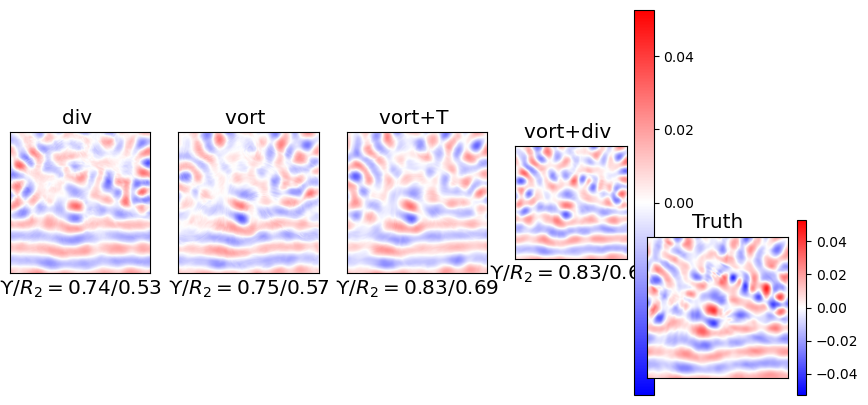

In [9]:
field_max = np.max(outputs_cosssh_comb)
field_min = np.min(outputs_cosssh_comb)
truth_snapshot = out_test[snap_index, 0]
model_ordering = ['div', 'vort','vort+T','vort+div']
fig=plt.figure(figsize = (10.5,5))
norm = TwoSlopeNorm(vcenter =0)
for i in range(nconfigs):
    plt.subplot(1, nconfigs+1,i+1)
    plt.imshow(outputs_cosssh_comb[i,snap_index, mid_slice, :], origin ='lower', cmap = ssh_cmap, norm=norm)
#     plt.colorbar()
    plt.clim(field_min, field_max)
    correlation = corr(truth_snapshot[mid_slice, :], outputs_cosssh_comb[i,snap_index, mid_slice, :])
    coeff_determ = L2_R(truth_snapshot[mid_slice, :], outputs_cosssh_comb[i,snap_index, mid_slice, :])
    print (correlation)
#     plt.text(40, 20, r'$\mathcal{\Upsilon}$ = ' +  str(round(correlation, 2)), fontsize = 'x-large')
#     plt.text(40, 60, r'$R_2$ = ' +  str(round(coeff_determ, 2)), fontsize = 'x-large')
    plt.xlabel(r'$\mathcal{\Upsilon}/R_2 = $'+ str(round(correlation, 2))+'/'+str(round(coeff_determ, 2)),
               fontsize = 'x-large')
    plt.xticks([])
    plt.yticks([])
    if i==3:
        plt.colorbar()

    plt.title('{} '.format(model_ordering[i]), fontsize = 'x-large')
plt.subplot(2,4,8)
plt.imshow(truth_snapshot[mid_slice, :] , origin ='lower', cmap = ssh_cmap, norm =norm)
plt.colorbar()
plt.title('Truth',  fontsize = 'x-large')
plt.xticks([])
plt.yticks([])
# plt.colorbar()
# plt.title('{} '.format(to_ssh_model_names[i]), fontsize = 'xx-large')
# fig.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

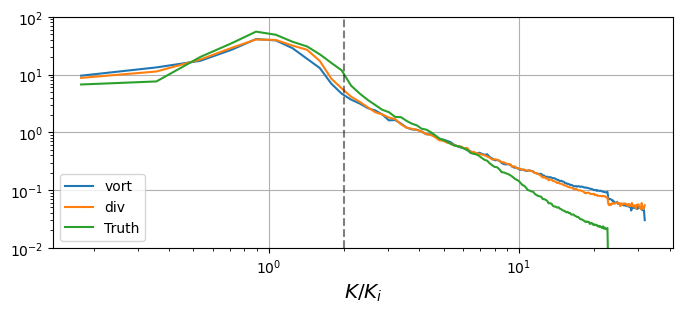

In [15]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
#     print ('nr', nr)
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr
#     print (radial_prof.shape, 'rad profile shape')

    return radial_prof


def spectrum(image):
    image_fft = fft.fft2(image)
    fshift = fft.fftshift(image_fft) + 1e-10
#     mag_spectrum = np.log(np.abs(fshift))
    mag_spectrum = np.abs(fshift)
    psd1D = azimuthalAverage(mag_spectrum)  
#     psd1D = (psd1D-np.min(psd1D))/(np.max(psd1D)-np.min(psd1D))
    return  psd1D

vort_wave_mid = vort_out_mod[snap_index,0, mid_slice, : ]
div_wave_mid = div_out_mod[snap_index,0, mid_slice, : ]
#vortdiv_wave_mid = vortdiv_out_mod[snap_index,0, mid_slice, : ]

true_wave_mid = out_test[snap_index,0, mid_slice, : ]

smvort = spectrum(vort_wave_mid)
smdiv = spectrum(div_wave_mid)
#smvortdiv = spectrum(vortdiv_wave_mid)

smTr = spectrum(true_wave_mid)

freq = np.fft.rfftfreq(179*2, d=1)/(2*np.pi/400) #the units here are probably grid spacing (4 km)

fig, ax  = plt.subplots(figsize = (8, 3))

plt.plot(freq[1:], smvort, label = r'vort')
plt.plot(freq[1:], smdiv, label = r'div')
#plt.plot(freq[1:], smvortdiv, label = r'vort+div')
plt.plot(freq[1:], smTr, label ='Truth')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.01, 100)
#plt.axvline(x=1, c='k', linestyle='-', alpha = 0.5) #, label =r'$x = 2 K_i$'
plt.axvline(x=2, c='k', linestyle='--', alpha = 0.5) #, label =r'$x = 2 K_i$'
plt.grid()
plt.xlabel(r'$K/K_i$', fontsize = 'x-large')
# ellipse = patches.Ellipse((2,10), 10,10, linewidth=1, edgecolor='r', facecolor='none')
plt.legend(loc='lower left')
plt.show()

